In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

%load_ext autoreload
%autoreload 2
from utils import show_heat_map, print_mutual_info, aggregate_data, resample_df, load_big_df
from utils import two_sig_signal, two_sig_signal_multi, get_yulu_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
df_raw = pd.read_csv("../simulation_data/output_2025-03-15_20250312_HYPEUSDTOB500_HYPEUSDTtrades_VX.csv")
# SUM_TRADE_SIZE = df_raw['trade_size'].sum()
df_buy, df_sell, df_ob = aggregate_data(df_raw)

In [45]:
df_ob.columns

Index(['mid', 'bidsize_1', 'bidsize_2', 'bidsize_3', 'bidsize_4', 'bidsize_5',
       'asksize_1', 'asksize_2', 'asksize_3', 'asksize_4', 'asksize_5',
       'bidprice_1', 'bidprice_2', 'bidprice_3', 'bidprice_4', 'bidprice_5',
       'askprice_1', 'askprice_2', 'askprice_3', 'askprice_4', 'askprice_5'],
      dtype='object')

In [274]:
def plot_ob(ts):
    start_ts = ts #- pd.Timedelta(seconds=10)
    end_ts = ts + pd.Timedelta(seconds=90)
    ddf = df_ob.loc[start_ts : end_ts][['mid', 'bidsize_1', 'bidsize_2', 'bidsize_3', 'bidsize_4', 'bidsize_5',
        'asksize_1', 'asksize_2', 'asksize_3', 'asksize_4', 'asksize_5']]


    fig, ax1 = plt.subplots(figsize=(50, 35))

    # ax1.plot(ddf.index, ddf['mid'], color=(1, 1, 1)) .rolling('4s').mean()

    for i in range(1, 6):
        ax1.plot(ddf.index, ddf[f'bidsize_{i}'], color=(1, 0, 0))
        ax1.plot(ddf.index, -ddf[f'asksize_{i}'], color=(0, 0, 1))
    
    ax1.axvline(ts + pd.Timedelta(seconds=10), color='green', label='Start')
    ax1.axvline(ts + pd.Timedelta(seconds=70), color='green', label='End')

    ax2 = ax1.twinx()
    ax2.plot(ddf.index, ddf['mid'], color=(0, 0, 0), linewidth=3)

In [50]:
ddf['1min_return'] = ddf['mid'] ddf['mid'].shift()

Index(['mid', 'bidsize_1', 'bidsize_2', 'bidsize_3', 'bidsize_4', 'bidsize_5',
       'asksize_1', 'asksize_2', 'asksize_3', 'asksize_4', 'asksize_5'],
      dtype='object')

In [40]:
df = pd.read_csv('dataframes/HYPEUSDT_mar16.csv', index_col='time', parse_dates=['time'])

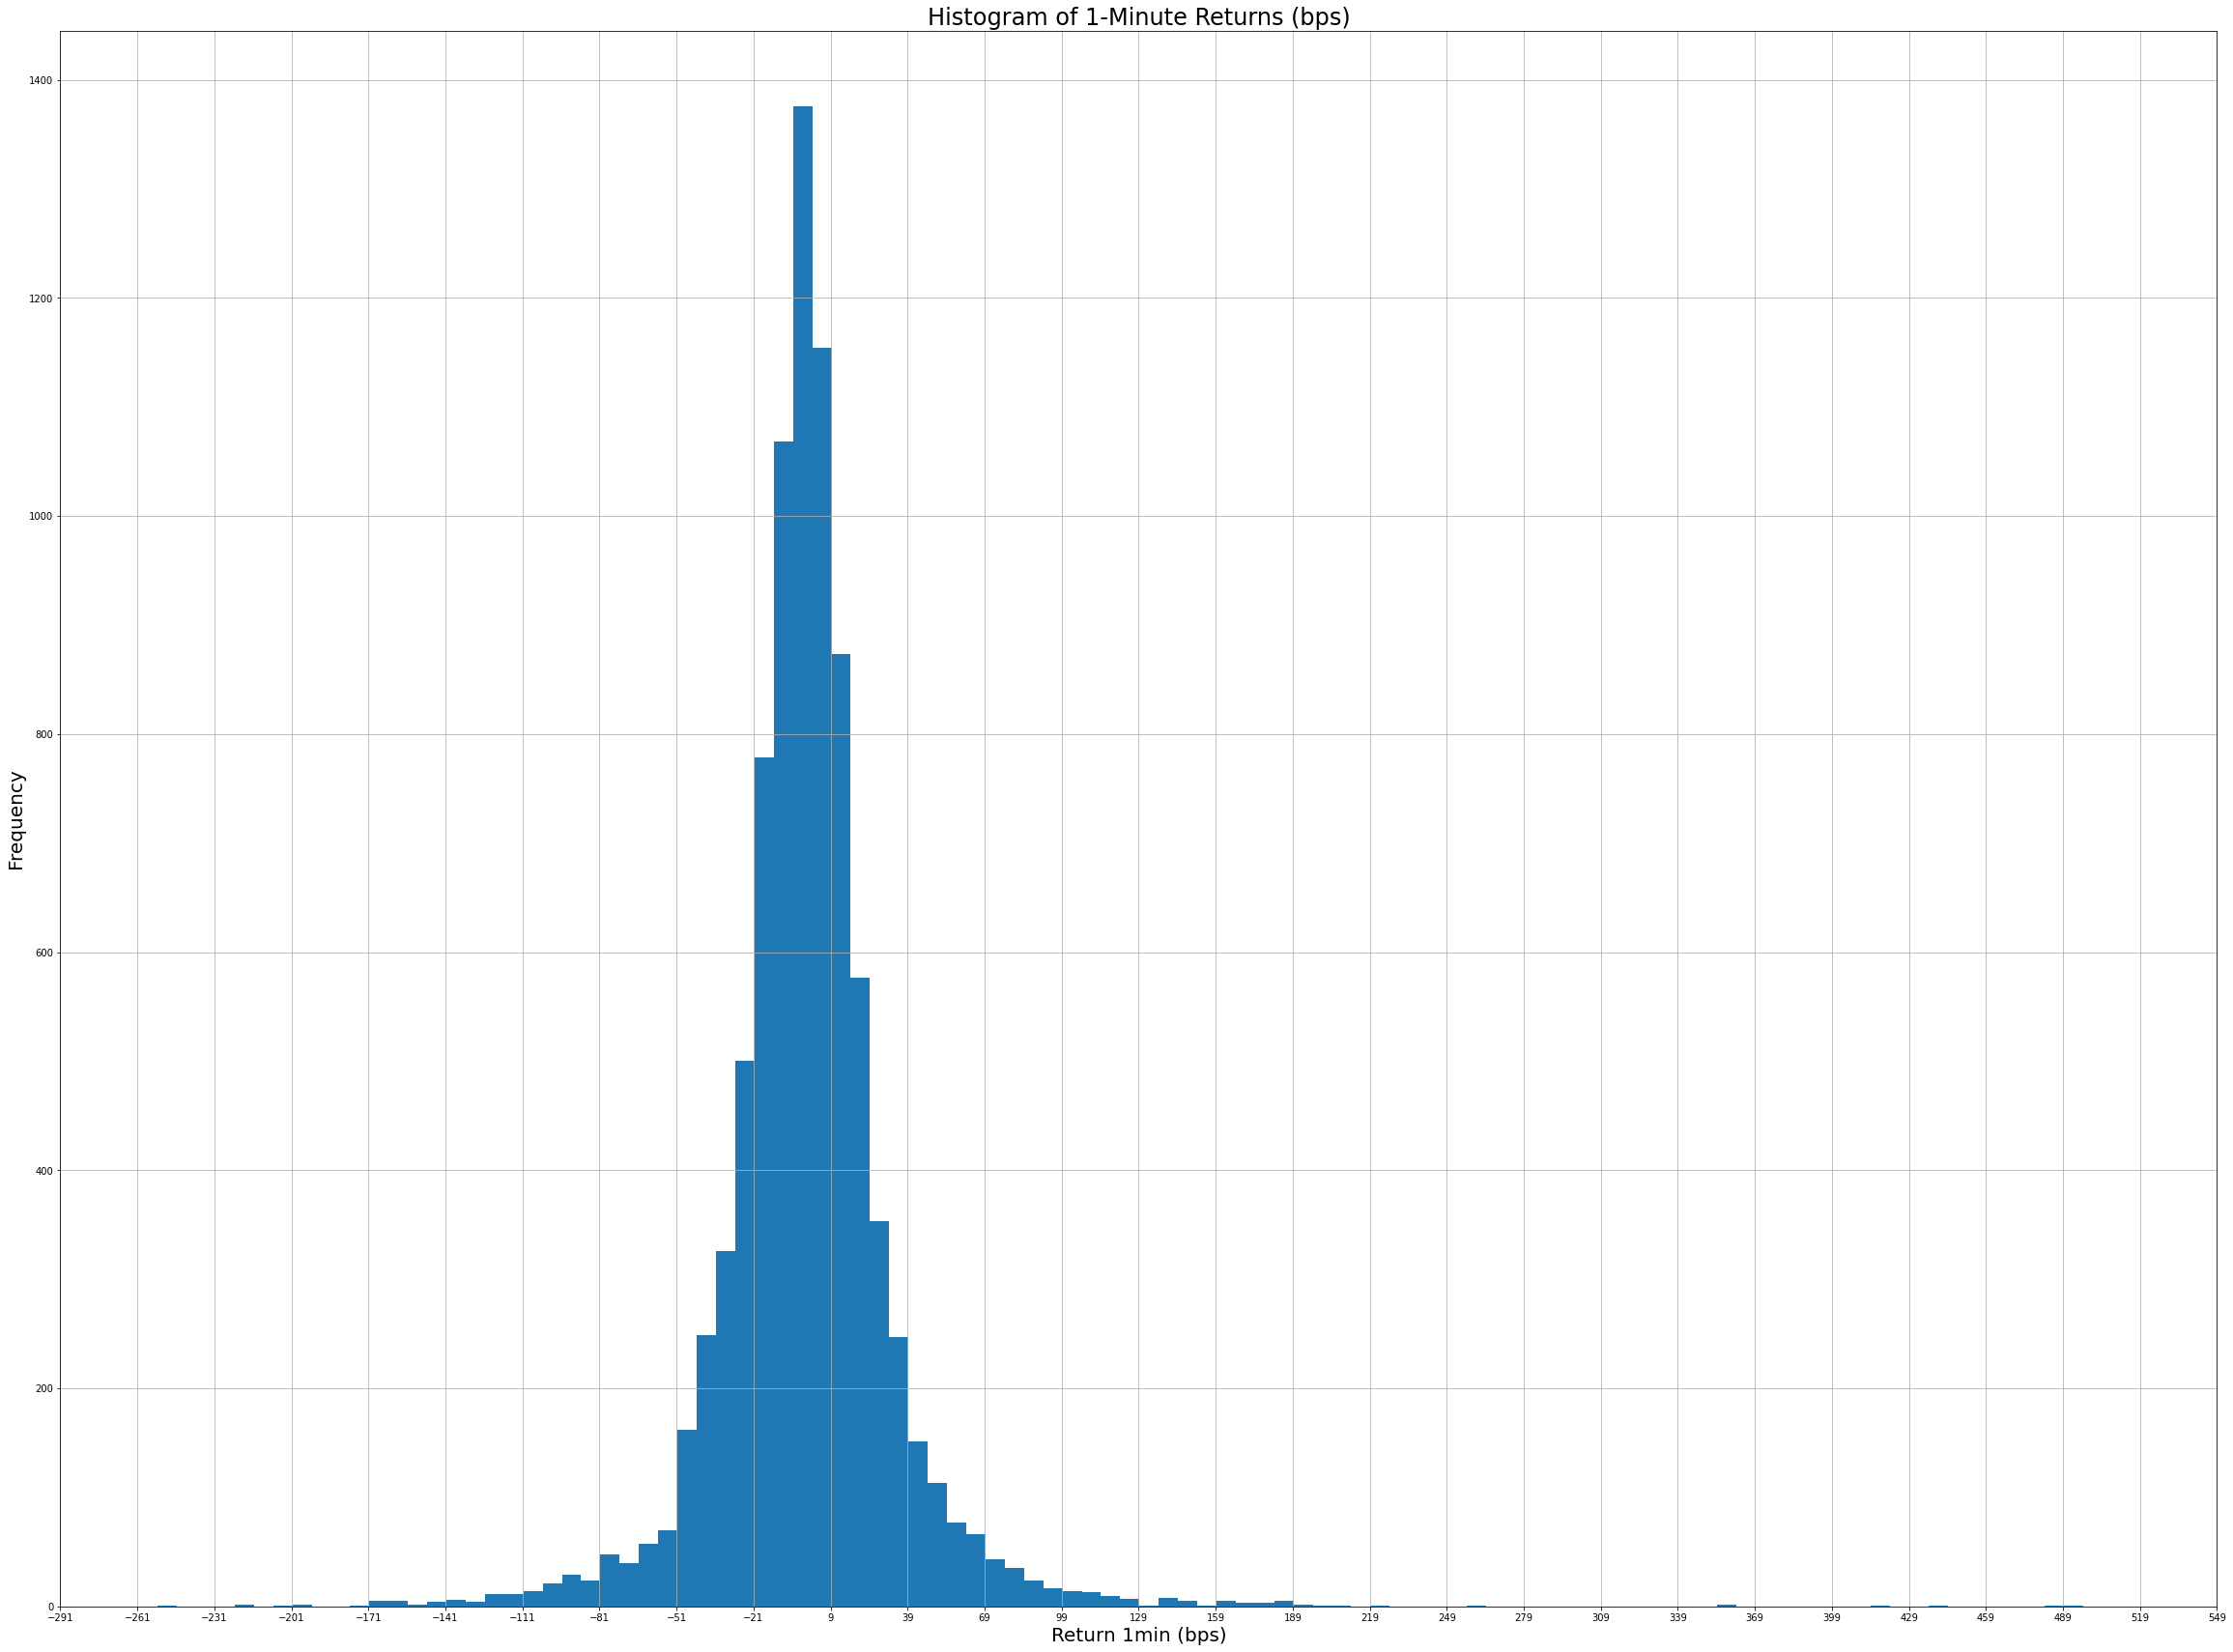

In [289]:
df1 = resample_df(df_buy, df_sell, df_ob, '10S')
df1['return_10s_bps'] = ((df1['mid'].shift(-1) / df1['mid']) - 1.0) * 10000.0
df1['return_1min_bps'] = ((df1['mid'].shift(-6) / df1['mid']) - 1.0) * 10000.0
# df1[['return_1min_bps']].plot(kind='hist', bins=100, figsize=(40, 30))
fig, ax = plt.subplots(figsize=(40, 30))
n, bins, patches = ax.hist(df1['return_1min_bps'].dropna(), bins=100)

# Set more granular x-ticks
tick_spacing = 30  # or 1 or 2 depending on how granular you want
xmin, xmax = ax.get_xlim()
xticks = np.arange(np.floor(xmin), np.ceil(xmax) + tick_spacing, tick_spacing)
ax.set_xticks(xticks)
ax.set_xlabel('Return 1min (bps)', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)
ax.set_title('Histogram of 1-Minute Returns (bps)', fontsize=24)
plt.grid(True)
plt.show()

0.03526712857127022


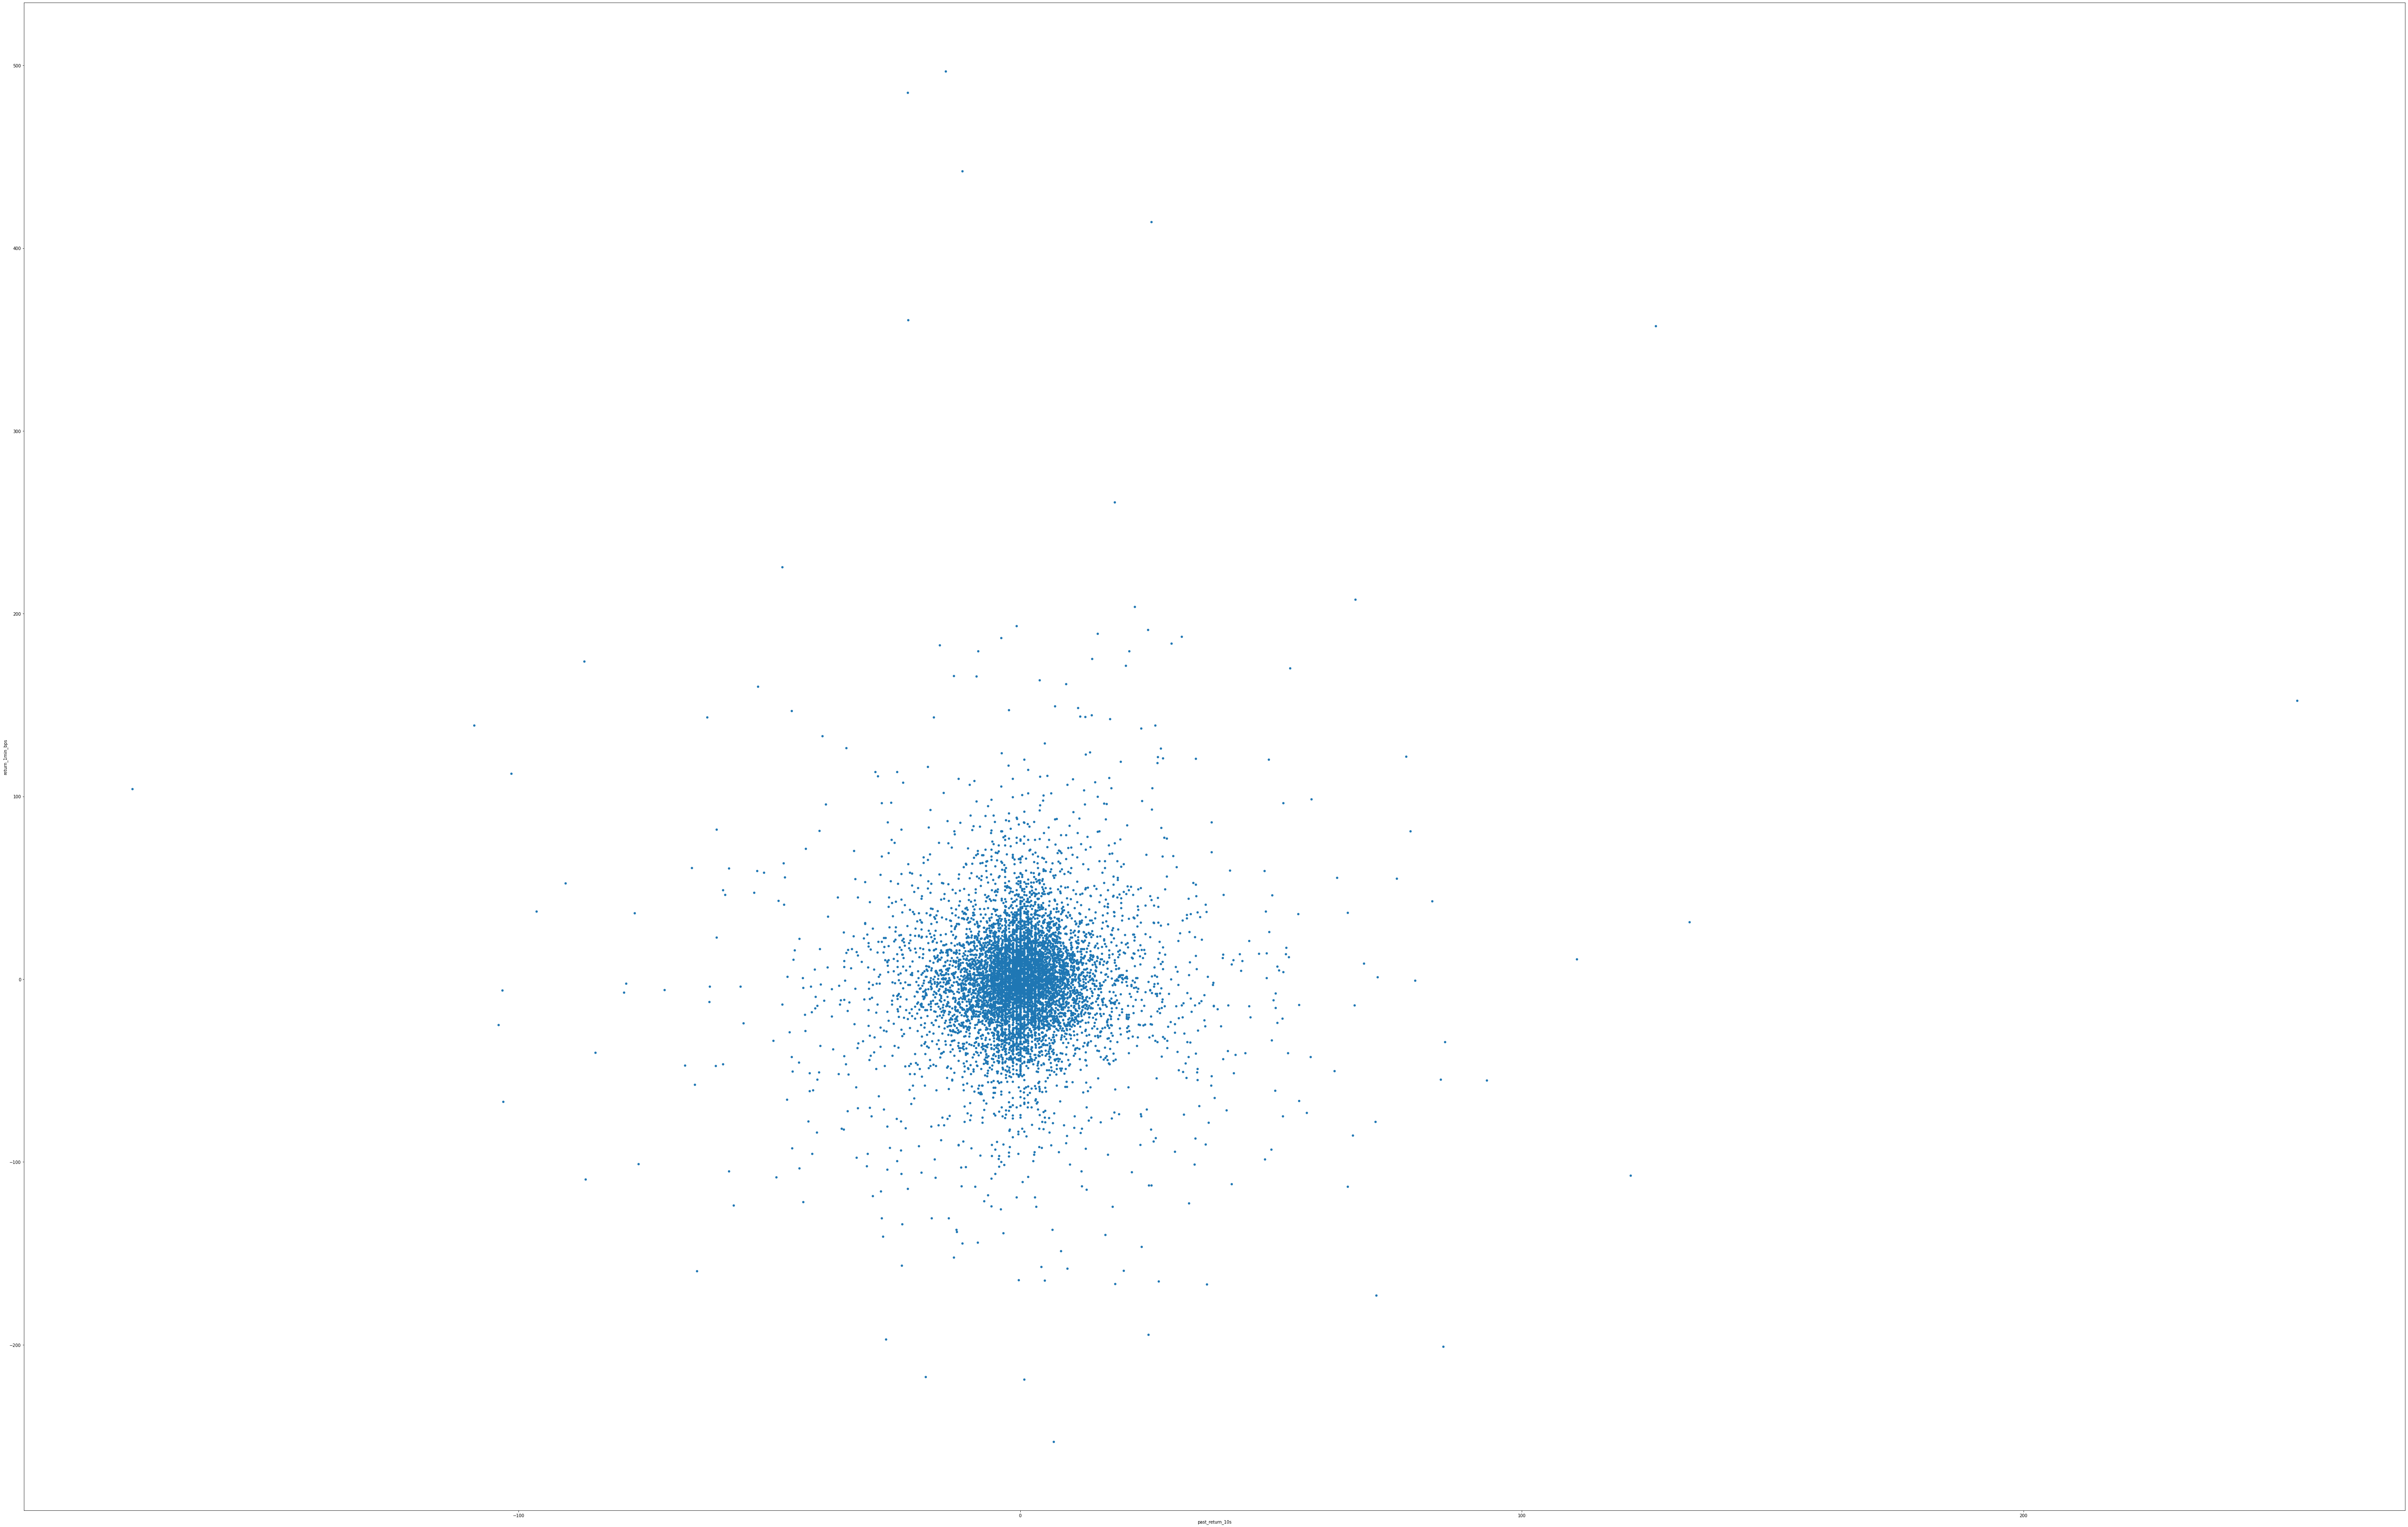

In [295]:
df1['past_return_10s'] = ((df1['mid'] / df1['mid'].shift(1)) - 1.0) * 10000.0
df1.plot(kind='scatter', x='past_return_10s', y='return_1min_bps', figsize=(100, 65))
print(df1['past_return_10s'].corr(df1['return_1min_bps']))

In [272]:
profit_ts = df1[df1['return_1min_bps'] > 20].index
profit_ts

# stale_ts = df1[df1['mid'].rolling('10s').agg(lambda x: (x.max() - x.min()) / x.min()) < 0.0003].index

# df_ob[df_ob['mid'].rolling('10s').agg(lambda x: (x.max() - x.min()) / x.min()) < 0.0003]

DatetimeIndex(['2025-03-12 00:00:00', '2025-03-12 00:00:10',
               '2025-03-12 00:04:10', '2025-03-12 00:04:20',
               '2025-03-12 00:04:30', '2025-03-12 00:04:40',
               '2025-03-12 00:10:00', '2025-03-12 00:10:20',
               '2025-03-12 00:10:30', '2025-03-12 00:10:40',
               ...
               '2025-03-12 23:50:20', '2025-03-12 23:50:30',
               '2025-03-12 23:50:40', '2025-03-12 23:50:50',
               '2025-03-12 23:51:00', '2025-03-12 23:51:10',
               '2025-03-12 23:51:20', '2025-03-12 23:51:30',
               '2025-03-12 23:51:40', '2025-03-12 23:51:50'],
              dtype='datetime64[ns]', name='time', length=1519, freq=None)

In [200]:
stale_ts = df_ob[df_ob['mid'].rolling('5s').max() / df_ob['mid'].rolling('5s').min() < 1.00001].index
stale_ts

DatetimeIndex(['2025-03-12 00:00:01.326999808',
               '2025-03-12 00:00:01.426000128',
               '2025-03-12 00:00:01.526000128',
               '2025-03-12 00:00:01.625999872',
               '2025-03-12 00:00:01.726000128',
               '2025-03-12 00:00:01.826999808',
               '2025-03-12 00:00:01.927000064',
               '2025-03-12 00:00:02.026000128',
               '2025-03-12 00:00:02.127000064',
               '2025-03-12 00:00:02.226000128',
               ...
               '2025-03-12 23:59:55.825999872',
               '2025-03-12 23:59:56.026000128',
               '2025-03-12 23:59:56.526000128',
               '2025-03-12 23:59:56.625999872',
               '2025-03-12 23:59:56.727000064',
               '2025-03-12 23:59:56.825999872',
               '2025-03-12 23:59:56.926000128',
               '2025-03-12 23:59:57.026000128',
               '2025-03-12 23:59:57.125999872',
               '2025-03-12 23:59:57.226000128'],
              dtype=

2025-03-12 00:35:10
22.336707857475435


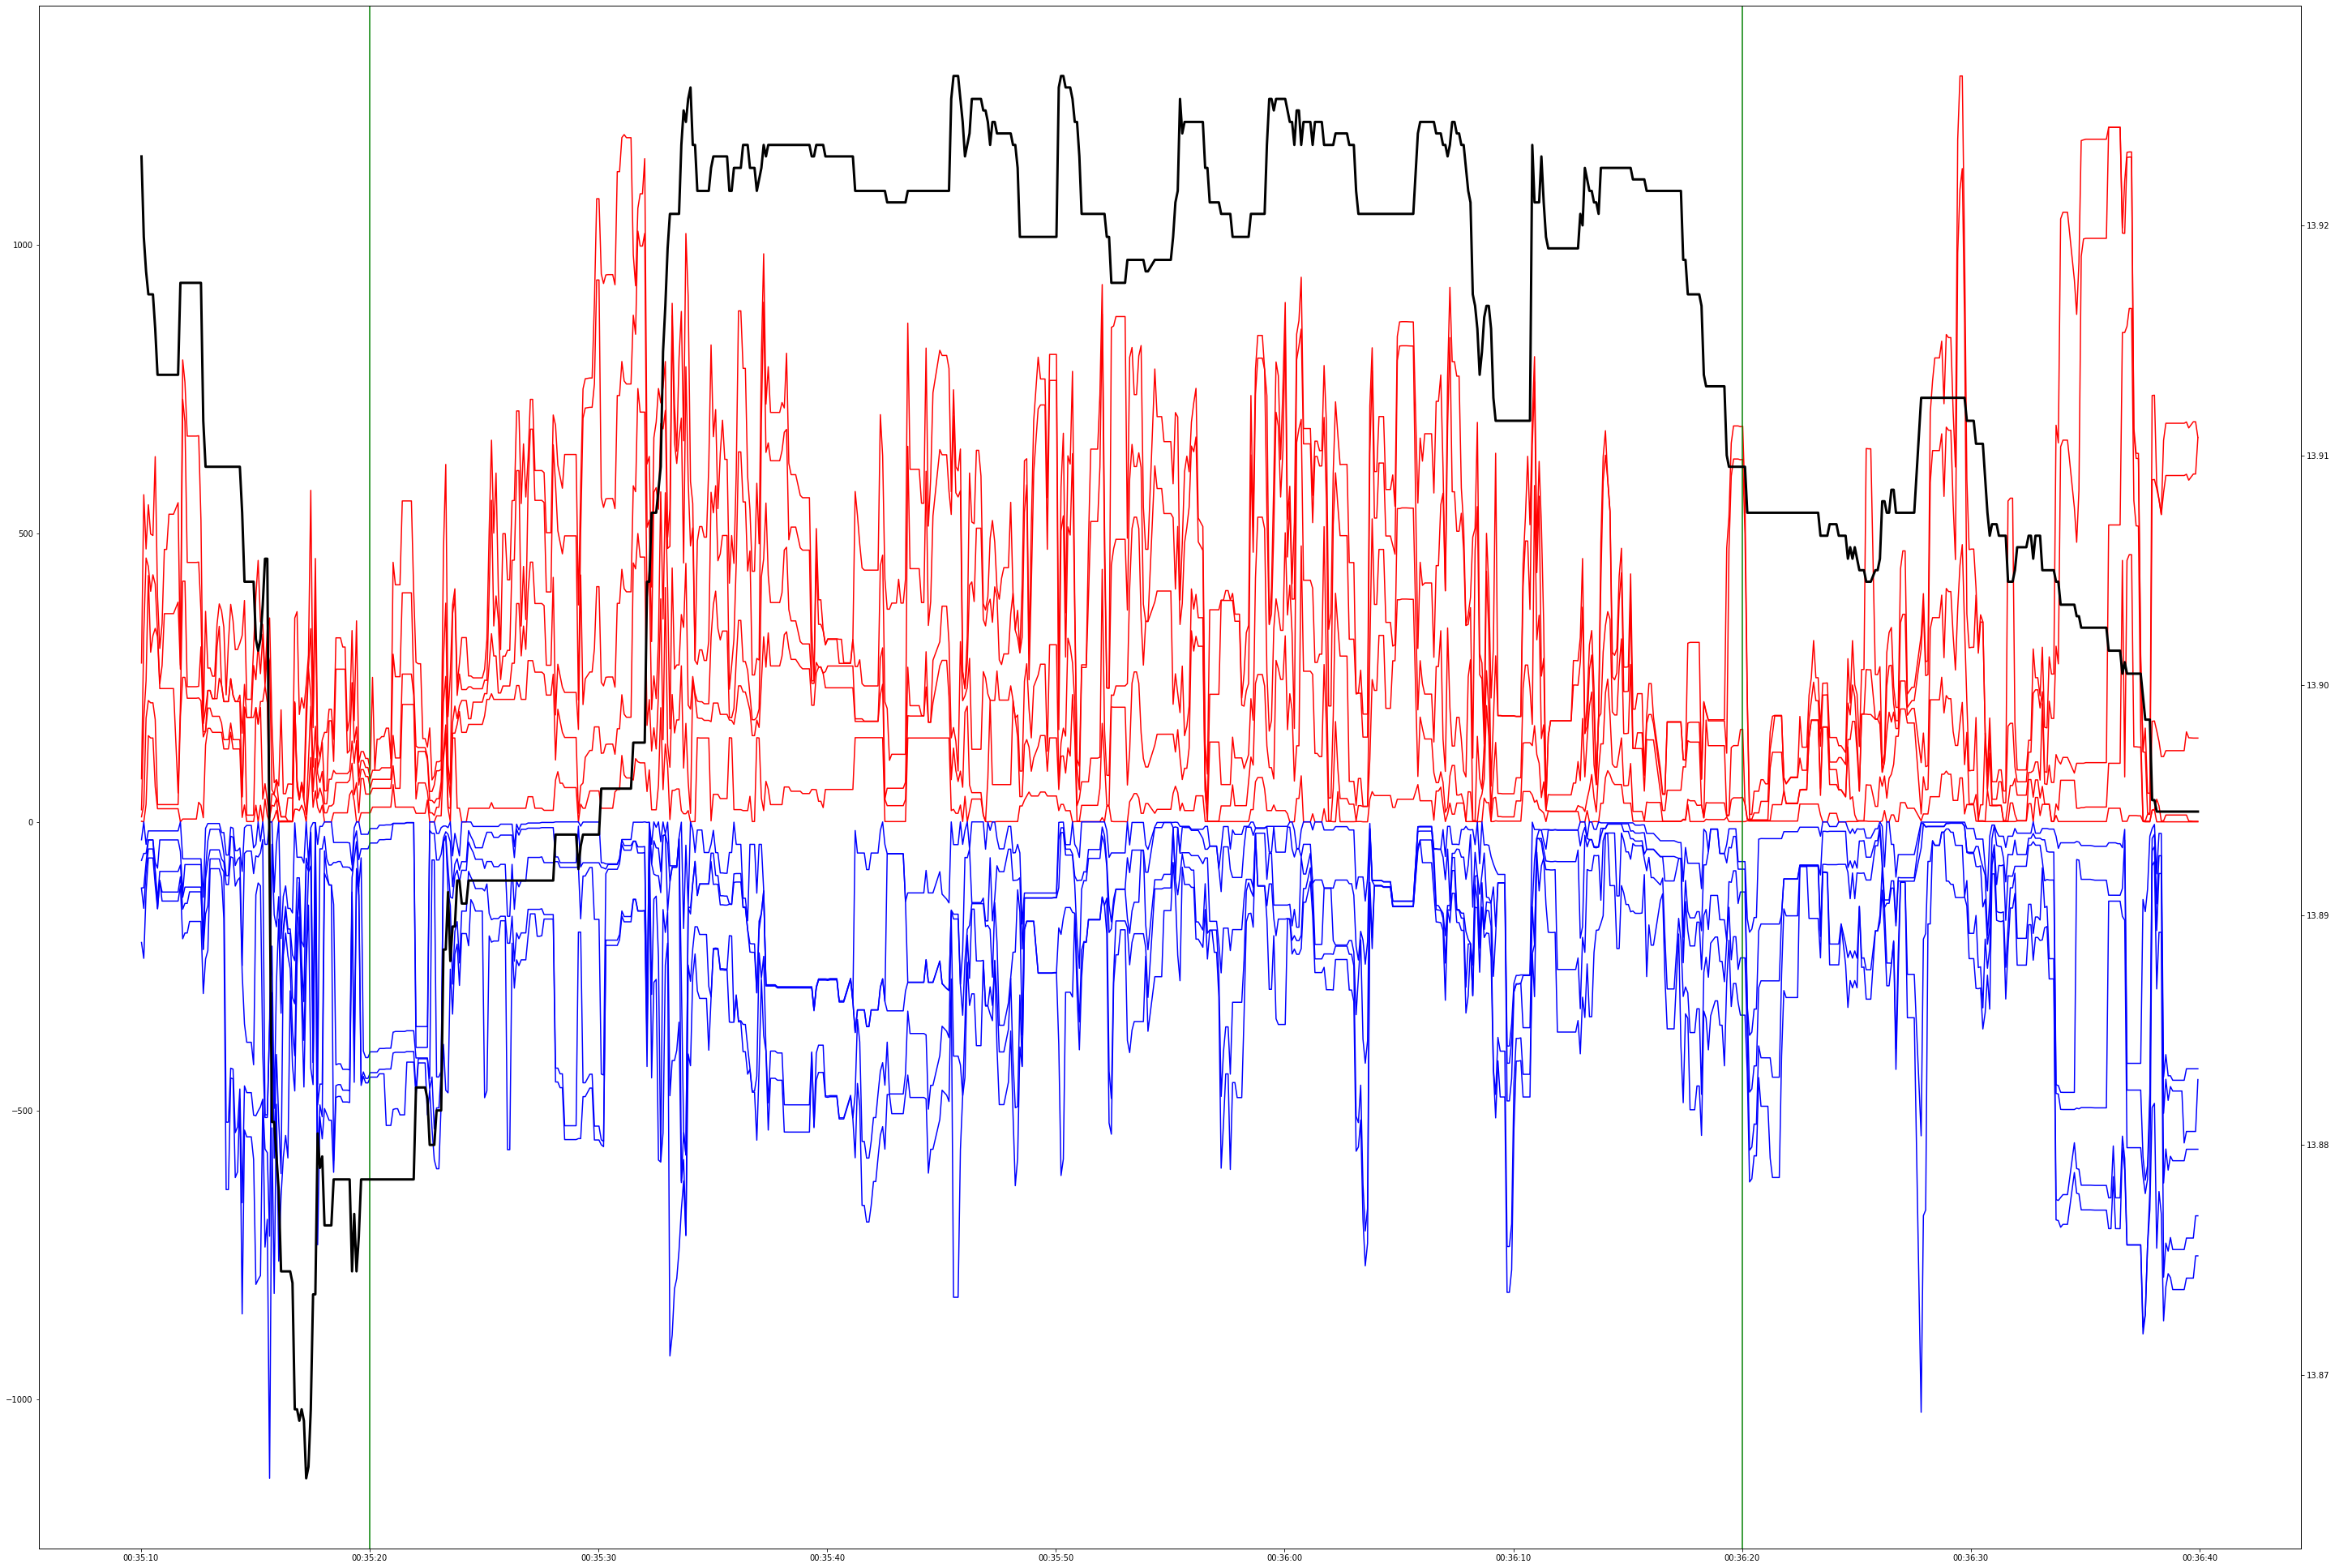

In [283]:
i += 3
# print(df1.loc[stale_ts[i]]['return_10s_bps'])
ts_list = profit_ts

print(ts_list[i])
axd = df_ob.loc[ts_list[i]+ pd.Timedelta(seconds=10): ts_list[i] + pd.Timedelta(seconds=70)]['mid']
print(((axd[-1] / axd[0]) - 1) * 10000.0)
plot_ob(ts_list[i])

In [262]:
mask = pd.Series(True, index=df_ob.index)
for i in range(1, 6):
    # print(df_ob[f'bidsize_{i}'].rolling('10S').std().quantile(0.1))
    val = df_ob[f'bidsize_{i}'].rolling('10S').std().quantile(0.2)
    mask = mask & (df_ob[f'bidsize_{i}'].rolling('10S').std() < val)
    print(len(df_ob[mask]))

for i in range(1, 6):
    val = df_ob[f'asksize_{i}'].rolling('10S').std().quantile(0.2)
    mask = mask & (df_ob[f'asksize_{i}'].rolling('10S').std() < val)
    # print(df_ob[f'asksize_{i}'].rolling('10S').std().quantile(0.1))

mask = mask & (df_ob['mid'].rolling('5s').max() / df_ob['mid'].rolling('5s').min() < 1.00001)

target_idx = df_ob[mask].index

df_ob['mid'] 

df_ob[f'bidsize_{i}'].rolling('10S').std()
df_ob[f'asksize_{i}'].rolling('10S').std()

156243
91935
69171
52969
42617


In [126]:
ddddf = pd.DataFrame({'A': [1,2,3], 'B': [4,5,6]})
ddddf.shift(-1)


,A,B
0,2.0,5.0
1,3.0,6.0
2,NaN,NaN
